In [33]:
import pandas as pd
from lib.llm_utils import PROMPT_TYPES

merged_df = pd.read_csv('data_samples/short-answers-10k.csv')
data_df = pd.read_csv('data_samples/askme-10k.csv')

rating_columns = {
    '1_word_answer_rating_score': '1 word',
    '2_words_answer_rating_score': '2 word',
    '3_words_answer_rating_score': '3 word',
    '4_words_answer_rating_score': '4 word',
    '5_words_answer_rating_score': '5 word',
    'few_words_answer_rating_score': 'few word',
}
answer_columns = [prompt + '_answer_text' for prompt in PROMPT_TYPES]
rating_data = merged_df[list(rating_columns.keys()) + answer_columns].rename(columns=rating_columns)
rating_only_data = rating_data[list(rating_columns.values())]
rating_stats = rating_data.describe().T[['mean', 'std']]

golden_answer_mean = data_df['value'].mean()
golden_answer_std = data_df['value'].std()
rating_stats.loc['golden answer'] = [golden_answer_mean, golden_answer_std]
word_counts = rating_data[answer_columns].applymap(lambda x: len(str(x).split()))
word_counts.columns = [column.split("_")[0] + ' word' for column in word_counts.columns]
word_count_stats = word_counts.describe().T[['mean', 'std']]

defiant = []
for column in word_counts.columns:
    limit = column.split()[0]
    if limit == 'few':
        continue
    ratio = (word_counts[column] > int(limit)).sum() / len(word_counts) * 100
    defiant.append(ratio)
defiant.extend(["N/A", "N/A"])

golden_answer_word_count = data_df['text'].apply(lambda x: len(str(x).split()))
word_count_stats.loc['golden answer'] = [golden_answer_word_count.mean(), golden_answer_word_count.std()]
word_count_stats['% defiant'] = defiant

combined_stats = pd.concat([rating_stats, word_count_stats], axis=1, keys=['Rating Stats', 'Word Count Stats'])
combined_stats

/tmp/ipykernel_52795/919176418.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  word_counts = rating_data[answer_columns].applymap(lambda x: len(str(x).split()))


Rating Stats           Word Count Stats                     
                      mean       std             mean        std % defiant
1 word              3.8803  1.255997           1.1496   1.081821       7.1
2 word              4.1725  1.118691           1.4704   0.960217      4.14
3 word              4.4209  0.937993           1.9658   0.824923      1.32
4 word              4.5981  0.762781           2.5549   0.943544      0.87
5 word              4.7029  0.635824           3.0260   1.255819      0.72
few word            4.8892  0.401920           5.8300   6.699133       N/A
golden answer       4.3595  1.306074          23.1824  22.004917       N/A

In [21]:
for column in word_counts.columns:
    limit = column.split()[0]
    if limit == 'few':
        continue
    # calculate the ratio of number of answers that exceed the limit
    ratio = (word_counts[column] > int(limit)).sum() / len(word_counts) * 100
    print(f"Ratio of answers with more than {limit} words: {ratio:.2f}%")


Ratio of answers with more than 5 words: 0.72%
Ratio of answers with more than 4 words: 0.87%
Ratio of answers with more than 3 words: 1.32%
Ratio of answers with more than 2 words: 4.14%
Ratio of answers with more than 1 words: 7.10%


In [38]:
word_counts

,5 word,4 word,3 word,2 word,1 word,few word,golden answer
0,3,3,2,1,1,3,16
1,5,3,2,2,2,25,9
2,4,2,2,2,1,5,19
3,2,2,1,1,1,1,9
4,2,2,2,1,1,3,20
...,...,...,...,...,...,...,...
9995,3,3,2,1,1,12,21
9996,3,3,2,1,1,3,16
9997,4,4,2,1,1,4,7
9998,4,4,4,2,1,10,29


/tmp/ipykernel_52795/175200073.py:21: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  rating_for_plot = rating_data[rating_columns.values()].apply(pd.value_counts).fillna(0).T
/tmp/ipykernel_52795/175200073.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data.index, rotation=45, ha="right")


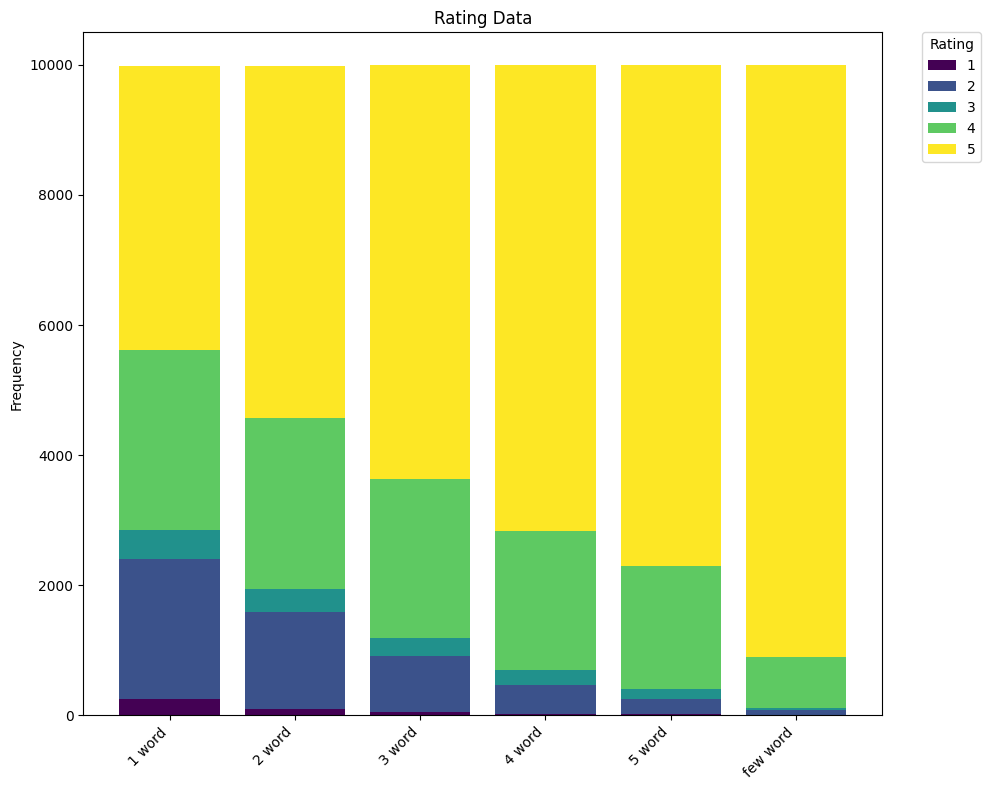

/tmp/ipykernel_52795/175200073.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data.index, rotation=45, ha="right")


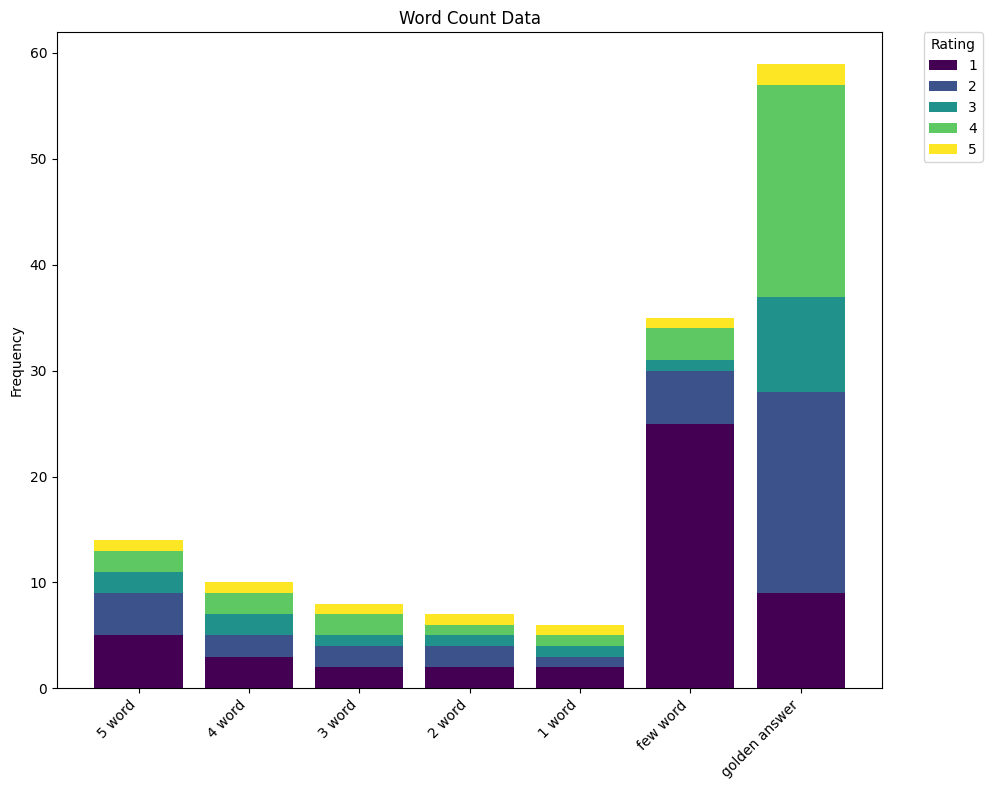

In [39]:
import matplotlib.pyplot as plt
import numpy as np

def plot_stacked_bar_chart(data, columns, title, ylabel):
    colors = plt.cm.viridis(np.linspace(0, 1, 5))  # Assuming ratings are from 1 to 5

    fig, ax = plt.subplots(figsize=(10, 8))
    bottom_values = np.zeros(len(data.index))
    for i, column in enumerate(columns):
        ax.bar(data.index, data[column], bottom=bottom_values, label=column, color=colors[i])
        bottom_values += data[column]
    
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    ax.set_xticklabels(data.index, rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Prepare data for rating stacked bar chart
rating_for_plot = rating_data[rating_columns.values()].apply(pd.value_counts).fillna(0).T

# Prepare data for word count stacked bar chart
word_counts['golden answer'] = golden_answer_word_count
word_count_for_plot = word_counts.T

# Plot for Rating Data
plot_stacked_bar_chart(rating_for_plot, [1, 2, 3, 4, 5], 'Rating Data', 'Frequency')

# Plot for Word Count Data
plot_stacked_bar_chart(word_count_for_plot, [1, 2, 3, 4, 5], 'Word Count Data', 'Frequency')

In [25]:
merged_df[['context']]

,context
0,"In an article about 'Photography in Denmark', ..."
1,"In an article about 'Antimony', section 'Appli..."
2,"In an article about 'Bunnies & Burrows', secti..."
3,"In an article about 'Zach Parise', section 'Pe..."
4,"In an article about 'Kurt Angle', section 'Pro..."
...,...
95,"In an article about 'Andalusian horse', sectio..."
96,"In an article about 'James Bond in film', sect..."
97,"In an article about 'Lead poisoning', section ..."
98,"In an article about 'The Stolen Earth', sectio..."


In [28]:
import pandas as pd

# Load the merged DataFrame
merged_df = pd.read_csv('data_samples/paragraph-questions-100-short-answers.csv')

# Define a threshold for low rating scores
low_rating_threshold = 3

# Create a function to filter and format data for each answer length
def filter_low_ratings(df, answer_length):
    return df[df[f'{answer_length}_answer_rating_score'] < low_rating_threshold][[
        'context', 'text_cleaned', 'text_question',
        f'{answer_length}_answer_text', f'{answer_length}_answer_rating_score', f'{answer_length}_answer_rating_rationale'
    ]].rename(columns={
        f'{answer_length}_answer_text': 'answer_text',
        f'{answer_length}_answer_rating_score': 'rating_score',
        f'{answer_length}_answer_rating_rationale': 'rating_rationale'
    }).assign(answer_length=answer_length.replace('_', ' ').capitalize())

# List of answer lengths to check
answer_lengths = ['1_word', '2_words', '3_words', '4_words', '5_words', 'few_words']

# Concatenate all the filtered DataFrames
low_ratings_samples = pd.concat([filter_low_ratings(merged_df, length) for length in answer_lengths], ignore_index=True)

# Optionally, save the filtered samples to a CSV for further inspection
low_ratings_samples.to_csv('data_samples/low_ratings_samples.csv', index=False)

low_ratings_samples

,context,text_cleaned,text_question,answer_text,rating_score,rating_rationale,answer_length
0,"In an article about 'Photography in Denmark', ...","Danish Museum of Photographic Art , Odense .",What is the name of the museum located in Oden...,Danish.,2.0,"The answer ""Danish"" is partially correct becau...",1 word
1,"In an article about 'Kurt Angle', section 'Pro...","At Final Resolution , Angle was booked to defe...",Who did Kurt Angle defeat in a thirty-minute I...,Samoa,2.0,"The answer provided, ""Samoa"", is partially cor...",1 word
2,"In an article about 'Bridgewater Canal', secti...","George Loch , who had been opposed to using th...","What canal was built between 1858-59, connecti...",Runcorn.,2.0,"The answer ""Runcorn"" is partially correct beca...",1 word
3,"In an article about 'Misty Copeland', section ...","In 1997 , Copeland won the Los Angeles Music C...",Which company did Misty Copeland become a memb...,ABT's.,2.0,"The answer ""ABT's"" is partially correct becaus...",1 word
4,"In an article about 'Archaea', section 'Ecolog...","In the sulfur cycle , archaea that grow by oxi...",What is the byproduct of sulfur oxidation by a...,Acid.,2.0,"The answer ""Acid"" is partially correct, as it ...",1 word
5,"In an article about 'Candida ( song )', sectio...",""" Candida "" was the first single released by t...","Who produced ""Candida"" for Bell Records?",Appell,2.0,"The answer ""Appell"" is partially correct becau...",1 word
6,"In an article about 'Characters of Myst', sect...","On Riven Atrus meets Catherine , a local inhab...","Who does Atrus meet on Riven, and what is her ...",Catherine.,2.0,"The answer provided, ""Catherine"", is partially...",1 word
7,"In an article about 'Animal coloration', secti...",According to Charles Darwin 's 1859 theory of ...,What happens to individuals with slightly bett...,Leave.,2.0,"The answer ""Leave"" is partially correct, but i...",1 word
8,"In an article about 'The Coral Island', sectio...",The major themes of the novel revolve around t...,"What is the basic subject of ""The Coral Island...",Castaways.,2.0,"The answer ""Castaways"" is partially correct, a...",1 word
9,In an article about 'Landscape painting in Sco...,"In the Victorian era , the tradition of Highla...",What was the title of the 1851 painting by Edw...,Monarch,2.0,"The answer provided, ""Monarch"", is partially c...",1 word
